In [1]:
from fastai.vision import *
from fastai.widgets import *

# Squash Classifier

I love winter squash. I typically hate summer squash. This classifier will help me make sure that I never accidentally purchase a zucchini squash when what I really want is an acorn squash.

# Take-aways from this lesson:
1. DO NOT expect the fast-ai course to be organized. For any given task you would like to complete, there are at least 3 different "official" resources that are supposed to guide you through the process:

- Video Lectures
- The Jupyter Notebooks that accompany the lessons
- The Course web-page. 
- And sometimes slack and the fast.ai official forums. 

All four of these resources are likely to give you conflicting instruction. YOU WILL STRUGGLE to do the most simple task because you have four different sets of instructions from the same organization on how to complete the task. You are likely to spend more time figuring out the contradictions than practicing deep learning. 

In [2]:
path = Path('data/squash')

In [3]:
types = ['butternut', 'pumpkin', 'acorn', 'zucchini', 'tromboncino']

In [4]:
# create directories for training data
for type in types:
    folder = type
    file = f'urls_{type}'
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

In [4]:
# make sure all my directories are in place
path.ls()

[PosixPath('data/squash/pumpkin'),
 PosixPath('data/squash/export.pkl'),
 PosixPath('data/squash/pumpkin.txt'),
 PosixPath('data/squash/tromboncino.txt'),
 PosixPath('data/squash/acorn.txt'),
 PosixPath('data/squash/cleaned.csv'),
 PosixPath('data/squash/tromboncino'),
 PosixPath('data/squash/.ipynb_checkpoints'),
 PosixPath('data/squash/acorn'),
 PosixPath('data/squash/butternut.txt'),
 PosixPath('data/squash/models'),
 PosixPath('data/squash/zucchini.txt'),
 PosixPath('data/squash/zucchini'),
 PosixPath('data/squash/butternut')]

In [6]:
for type in types:
    download_images(path/f'{type}.txt', path/f'{type}/')

In [7]:
# verify all the URLs work and the images aren't broken:
for type in types:
    print(type)
    verify_images(path/type, delete=True, max_size=500)

butternut


pumpkin


acorn


zucchini


tromboncino


In [10]:
# Clean the data on a combined databunch (no test/train/valid split:)

# combined databunch
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [11]:
# create CNN. This CNN's top losses will be used to clean the image data:
cleaner = cnn_learner(db, models.resnet34, metrics=error_rate)

In [12]:
# Train the cleaning model for a few epochs:
cleaner.fit_one_cycle(4, max_lr=1e-3)

In [13]:
ds, idxs = DatasetFormatter().from_toplosses(cleaner)

In [15]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

In [16]:
doc(ImageDataBunch)

In [5]:
# Create NEW ImageDataBunch using 'cleaned.csv'. This one will split data into train/valid/test
np.random.seed(333)
data = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,).normalize(imagenet_stats)

In [6]:
# Take a look at the classes in our ImageDataBunch. This should match the classes we made 
# file paths for. If not check previous steps.
data.classes, len(data.train_ds), len(data.valid_ds)

(['acorn', 'butternut', 'pumpkin', 'tromboncino', 'zucchini'], 216, 54)

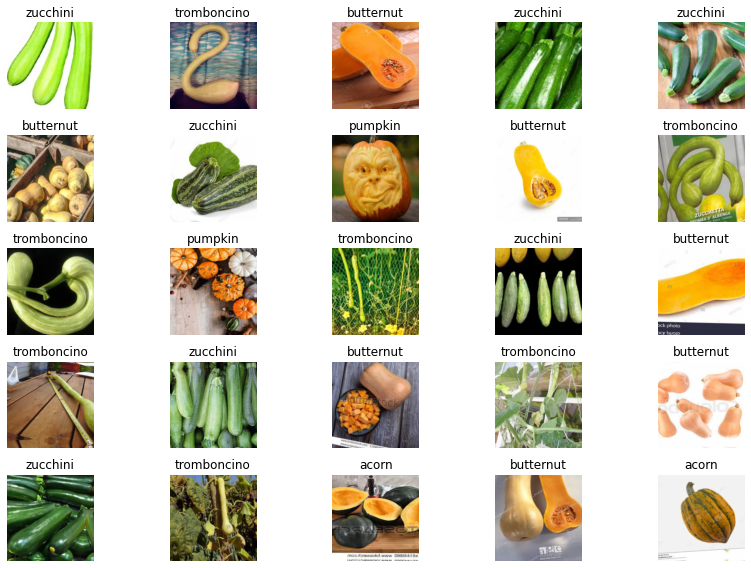

In [19]:
#Take a peek at our data.
data.show_batch(rows=5, figsize=(12,8))

In [7]:
# create brand new learner that we will fit to the cleaned DataBunch
learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [21]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


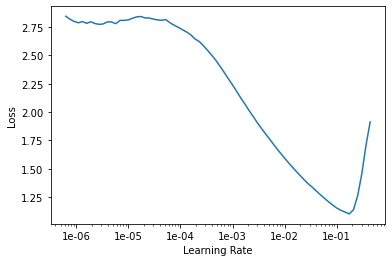

In [22]:
learner.recorder.plot()

In [8]:
#The plot above looks to have a nice steep downslope at 5e-3, so I'm going to try that:
learner.fit_one_cycle(5, max_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.704364,1.392567,0.425926,00:21
1,1.636136,0.719492,0.222222,00:22
2,1.124492,0.331368,0.129630,00:23
3,0.831371,0.187469,0.055556,00:22
4,0.658696,0.128168,0.055556,00:23


In [9]:
doc(learner.export)

In [11]:
learner.export()

In [31]:
# Let's take a look at how our learner is doing:
interp = ClassificationInterpretation.from_learner(learner)

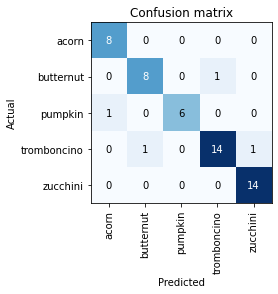

In [32]:
interp.plot_confusion_matrix()

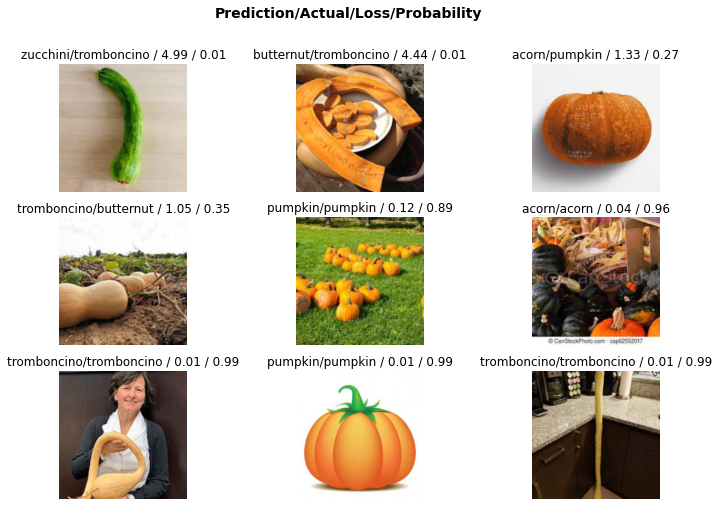

In [33]:
interp.plot_top_losses(9, figsize=(12,8))

In [34]:
learner.export()

In [35]:
defaults.device = torch.device('cpu')

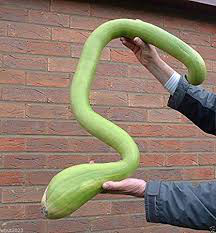

In [41]:
img = open_image('images.jpg')
img

In [42]:
learner.predict(img)

(Category tromboncino,
 tensor(3),
 tensor([2.5952e-14, 1.1580e-12, 1.1145e-10, 1.0000e+00, 1.0003e-09]))